In [1]:
import pandas as pd
import numpy as np
from Breakdown import df_transform
from UniVectorizer import Vectorizer
from MvideoPreprocessor import TextPreprocessor

# Препроцессинг

In [2]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
sw = stopwords.words('Russian')
sw += ['ответ', 'подходит', 'спасибо', 'здравствуйте', 'добрый', 'день', 'こんにちは4464', 'мочь', 'подсказать', 'привет', '⅞4467', 'заказ',
       'товар', 'клиент', 'жанар', 'жанна', 'жарков', 'жать', 'могу', 'создать', 'делать', 'сделать', 'который', 'вопрос']

df = df_transform(pd.read_excel('empom_autofaq.xlsx'))
tp = TextPreprocessor(method='lemma', stop_words=sw)
df['line'] = tp.fit_transform(df['line'])

vect = Vectorizer('tfidf', max_df=0.9, min_df=0.01, ngram_range=(1, 2))
X = vect.fit_transform(df['line'])
user_messages = X[df['sender'] == 'user']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\apple\DataspellProjects\stuff.ipynb\Breakdown.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df['user'] = df['Пользователь'].str.replace(r'\n-', '')
C:\Users\apple\DataspellProjects\stuff.ipynb\Breakdown.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['user'] = df['user'].str.replace(r'\n.*', '')
C:\Users\apple\DataspellProjects\stuff.ipynb\Breakdown.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['operators'] = df['Операторы'].str.replace(r'\n', '')
C:\Users\apple\DataspellProjects\stuff.ipynb\Breakdown.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sender'] = df['sender'].str.replace(r' \(р

In [3]:
!pip install kneed

# Сколько кластеров?
(для оценки использовал инерцию от KMeans)

In [4]:
!pip install tqdm

100%|██████████| 49/49 [01:48<00:00,  2.21s/it]


<Figure size 360x360 with 0 Axes>

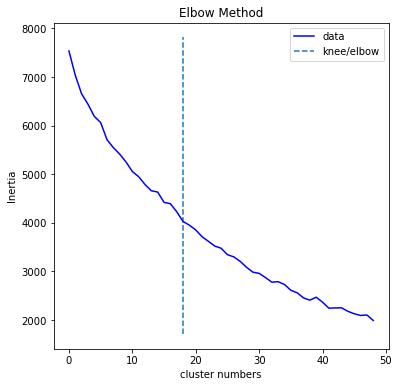

Optimal number of clusters: 18


In [5]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
from tqdm import tqdm

K = range(1, 50)
inertia = []
for k in tqdm(K):
    mb_kmeans = KMeans(n_clusters = k)
    mb_kmeans.fit(user_messages)
    inertia.append(mb_kmeans.inertia_)

i = np.arange(len(inertia))
knee = KneeLocator(i, inertia, S=1, curve='convex', direction='decreasing', interp_method='polynomial')


fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.ylabel("Inertia")
plt.show()

print(f"Optimal number of clusters: {knee.knee}")

# Function for topic-definition (LDA)

In [6]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import silhouette_score

def get_topics(data, labels, terms):
    lda = LDA(n_components=1)
    for c in range(max(labels) + 1):
        lda.fit(data[labels == c])

        word_list = []
        print(f"Topic {c}:")
        for j in lda.components_.argsort()[0,-16:-1]:
            word_list.append(terms[j])
        print(word_list)

k = knee.knee

# MiniBatch KMeans

In [7]:
from sklearn.cluster import MiniBatchKMeans

# k = 15
mb_kmeans = MiniBatchKMeans(n_clusters=k)
mb_kmeans.fit(user_messages)

print(f"Silhouette for MiniBatch KMeans: {silhouette_score(user_messages, mb_kmeans.labels_)}")
get_topics(user_messages, mb_kmeans.labels_, vect.get_feature_names())

Silhouette for MiniBatch KMeans: 0.5489617058319967
Topic 0:
['статус', 'помочь', 'зарезервировать', 'найти', 'регламент', 'дать', 'оплата', 'сотрудник', 'проблема', 'выдача', 'касса', 'ошибка', 'резерв', 'инструкция', 'тн']
Topic 1:
['статус', 'нужно', 'выдача', 'оформить', 'необходимо', 'дать', 'обратиться', 'найти', 'заявка', 'ошибка', 'оплата', 'магазин', 'продажа', 'касса', 'возврат']
Topic 2:
['проблема', 'дать', 'необходимо', 'нужно', 'карта', 'чек', 'заявка', 'оплата', 'обратиться', 'ошибка', 'оформить', 'магазин', 'решение', 'инструкция', 'касса']
Topic 3:
['выдача', 'оплата', 'скидка', 'чек', 'дать', 'касса', 'товарный', 'тн', 'ошибка', 'связанный', 'доставка', 'магазин', 'статус', 'резерв', 'зарезервировать']
Topic 4:
['sap', 'данный', 'ошибка', 'коллега', 'обратиться', 'писать', 'заявка', 'необходимо', 'новый', 'возврат', 'дать', 'работа', 'сотрудник', 'магазин', 'скидка']
Topic 5:
['обратиться', 'данный', 'связанный', 'оформить', 'возврат', 'статус', 'скидка', 'выдать', 'к

# Regular KMeans

In [8]:
from sklearn.cluster import KMeans

# k = 15
kmeans = KMeans(n_clusters=k)
kmeans.fit(user_messages)

print(f"Silhouette for Regular KMeans: {silhouette_score(user_messages, kmeans.labels_)}")
get_topics(user_messages, kmeans.labels_, vect.get_feature_names())

Silhouette for Regular KMeans: 0.5689895721096957
Topic 0:
['обратиться', 'связанный', 'помочь', 'писать', 'найти', 'склад', 'позиция', 'статус', 'оплата', 'зарезервировать', 'оплатить', 'товарный', 'выдача', 'ошибка', 'выдать']
Topic 1:
['помочь', 'выдать', 'номер', 'связанный', 'необходимо', 'возврат', 'склад', 'нужно', 'ошибка', 'выдача', 'позиция', 'статус', 'оплатить', 'магазин', 'оформить']
Topic 2:
['оплатить', 'доставка', 'писать', 'товарный', 'оплата', 'статус', 'помочь', 'номер', 'выдача', 'ошибка', 'зарезервировать', 'связанный', 'склад', 'магазин', 'позиция']
Topic 3:
['ошибка', 'рабочий', 'действие', 'склад', 'информация', 'сотрудник', 'магазин', 'касса', 'sap', 'помочь', 'ссылка', 'продажа', 'найти', 'возврат', 'работа']
Topic 4:
['нужно', 'новый', 'помочь', 'доставка', 'писать', 'обратиться', 'проверить', 'магазин', 'данный', 'ошибка', 'номер', 'продажа', 'касса', 'чек', 'возврат']
Topic 5:
['коллега', 'работа', 'необходимо', 'склад', 'товарный', 'помочь', 'ошибка', 'сот

In [20]:
!pip install pyLDAvis # Использовать https://github.com/lovit/kmeans_to_pyLDAvis для визуализации кластеров

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136900 sha256=1cc26eaec83cc3fb4878346bff34a099e3f939099a7dca80e49bca2c0ecb8997
  Stored in directory: c:\users\mcseem\appdata\local\pip\cache\wheels\90\61\ec\9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=151007260f12ae13e725550c8520c7ebd2b9bc2d9ab68ac053df2f09f4c5ce6b
  Stored in directory: c:\users\mcseem\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successful

# DBSCAN

In [34]:
from sklearn.cluster import DBSCAN

for e in range(70, 81, 1):
    db = DBSCAN(eps=e/100).fit(user_messages)
    clusters = dict().fromkeys(db.labels_, 0)
    for l in db.labels_:
        clusters[l] += 1
    print(f"Eps: {e/100}\t|{clusters}")

Eps: 0.7	|{0: 6769, 1: 7691, -1: 631, 2: 1900, 3: 48, 4: 43, 5: 46, 6: 8, 7: 11, 8: 24, 11: 9, 9: 13, 10: 6}
Eps: 0.71	|{0: 6769, 1: 7769, -1: 553, 2: 1900, 3: 48, 4: 43, 5: 46, 6: 8, 7: 11, 8: 24, 11: 9, 9: 13, 10: 6}
Eps: 0.72	|{0: 6769, 1: 7842, -1: 480, 2: 1900, 3: 48, 4: 43, 5: 46, 6: 8, 7: 11, 8: 24, 11: 9, 9: 13, 10: 6}
Eps: 0.73	|{0: 6769, 1: 7903, -1: 415, 2: 1900, 3: 52, 4: 43, 5: 46, 6: 8, 7: 11, 8: 24, 11: 9, 9: 13, 10: 6}
Eps: 0.74	|{0: 6769, 1: 8047, -1: 347, 2: 1900, 3: 52, 4: 46, 5: 8, 6: 11, 7: 13, 8: 6}
Eps: 0.75	|{0: 6769, 1: 8121, -1: 279, 2: 1900, 3: 63, 4: 46, 5: 8, 6: 13}
Eps: 0.76	|{0: 6769, 1: 8303, -1: 206, 2: 1900, 3: 8, 4: 13}
Eps: 0.77	|{0: 6769, 1: 8350, -1: 158, 2: 1900, 3: 9, 4: 13}
Eps: 0.78	|{0: 6769, 1: 10283, -1: 134, 2: 13}
Eps: 0.79	|{0: 6769, 1: 10305, -1: 112, 2: 13}
Eps: 0.8	|{0: 6769, 1: 10337, -1: 93}


In [36]:
print(f"Silhouette for DBSCAN: {silhouette_score(user_messages, db.labels_)}")
get_topics(user_messages, db.labels_, vect.get_feature_names())

Silhouette for DBSCAN: 0.24331923872562042


C:\Users\apple\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:811: RuntimeWarning: invalid value encountered in double_scalars
  perword_bound = bound / word_cnt


Topic 0:
['мочь', 'магазин', 'который', 'корпоративный', 'коллега', 'код', 'уточнить', 'клиент', 'карта', 'какой', 'инцидент', 'информация', 'инструкция', 'заявка', 'касса']
Topic 1:
['инцидент', 'ошибка', 'код', 'касса', 'номер', 'заявка', 'быть', 'чек', 'доставка', 'мочь', 'возврат', 'товар', 'клиент', 'магазин', 'заказ']


# Agglomerative Clustering

In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation as LDA

agg_res = AgglomerativeClustering(n_clusters=k)
agg_res.fit(user_messages.toarray())

print(f"Silhouette score for Agglomerative: {silhouette_score(user_messages, agg_res.labels_)}")
get_topics(user_messages, agg_res.labels_, vect.get_feature_names())

Silhouette score for Agglomerative: 0.5545865493143752
Topic 0:
['регламент', 'необходимо', 'оформить', 'sap', 'проблема', 'писать', 'crm', 'возврат', 'данный', 'ошибка', 'оплатить', 'статус', 'касса', 'магазин', 'выдать']
Topic 1:
['необходимо', 'продажа', 'решение', 'карта', 'заявка', 'номер', 'резерв', 'данный', 'статус', 'магазин', 'возврат', 'чек', 'оплата', 'ошибка', 'оплатить']
Topic 2:
['номер', 'инцидент', 'писать', 'доставка', 'позиция', 'заявка', 'продажа', 'возврат', 'данный', 'найти', 'касса', 'магазин', 'работа', 'регламент', 'сотрудник']
Topic 3:
['сотрудник', 'дать', 'заявка', 'помочь', 'статус', 'чек', 'связанный', 'данный', 'номер', 'ошибка', 'доставка', 'магазин', 'зарезервировать', 'резерв', 'позиция']
Topic 4:
['необходимо', 'нужно', 'писать', 'доставка', 'магазин', 'ошибка', 'проверить', 'дать', 'данный', 'обратиться', 'продажа', 'касса', 'номер', 'чек', 'возврат']
Topic 5:
['данный', 'инцидент', 'выдать', 'инструкция', 'дать', 'ошибка', 'номер', 'выдача', 'необхо

# BIRCH

In [10]:
from sklearn.cluster import Birch
birch = Birch(n_clusters=k)
birch.fit(user_messages)

print(f"Silhouette score for BIRCH: {silhouette_score(user_messages, birch.labels_)}")
get_topics(user_messages, birch.labels_, vect.get_feature_names())

Silhouette score for BIRCH: 0.5192360270251538
Topic 0:
['позиция', 'чек', 'возврат', 'выдача', 'корпоративный', 'найти', 'касса', 'уточнить', 'вложение', 'работа', 'инцидент', 'сотрудник', 'коллега', 'писать', 'регламент']
Topic 1:
['доставка', 'возврат', 'рабочий', 'необходимо', 'новый', 'ссылка', 'нужно', 'работа', 'решение', 'найти', 'сотрудник', 'дать', 'инструкция', 'инцидент', 'заявка']
Topic 2:
['нужно', 'найти', 'инструкция', 'решение', 'ошибка', 'оплатить', 'заявка', 'магазин', 'оформить', 'продажа', 'оплата', 'касса', 'номер', 'код', 'чек']
Topic 3:
['оформить', 'sap', 'чек', 'тн', 'сотрудник', 'необходимо', 'найти', 'обратиться', 'данный', 'доставка', 'заявка', 'магазин', 'оплата', 'действие', 'информация']
Topic 4:
['удаться', 'статус', 'выдача', 'оплата', 'оформить', 'необходимо', 'склад', 'номер', 'позиция', 'данный', 'помочь', 'магазин', 'связанный', 'товарный', 'зарезервировать']
Topic 5:
['позиция', 'статус', 'возврат', 'магазин', 'инструкция', 'ссылка', 'номер', 'дос

# Visualizing clusters with PyLDAvis

In [11]:
!pip install pyLDAvis

In [13]:
import pyLDAvis
from kmeans_to_pyLDAvis.kmeans_to_pyLDAvis import kmeans_to_prepared_data

prep = kmeans_to_prepared_data(user_messages, vect.get_feature_names(), kmeans.cluster_centers_,
                               kmeans.labels_, embedding_method='tsne')

pyLDAvis.display(prep)

C:\Users\apple\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
C:\Users\apple\DataspellProjects\stuff.ipynb\kmeans_to_pyLDAvis\kmeans_to_pyLDAvis\proportion.py:104: RuntimeWarning: invalid value encountered in true_divide
  term_proportion = weighted_centers / weighted_center_sum
C:\Users\apple\DataspellProjects\stuff.ipynb\kmeans_to_pyLDAvis\kmeans_to_pyLDAvis\proportion.py:71: RuntimeWarning: invalid value encountered in true_divide
  term_proportion = weighted_centers / weighted_centers.sum(axis=0)


In [14]:
with open("kmeans_vis.html", "w") as f:
    pyLDAvis.save_html(prep, f)